<h1><b>Analysis of NIH Chest X-ray Dataset</b></h1>
<h4>Editor: Daniel Wang</h4>

One of the common applications of machine learning is the healthcare AI. To better improve the accessibility and reliability of AI for clinical applications, we shall care about the data we collected. In this project, I will analyze the [NIH Chest X-ray Dataset](https://www.kaggle.com/nih-chest-xrays/data), which is usually used for some deep learning pre-trained models and is comprised of many X-ray images and corresponded structured metadata (stored in CSV format).

To do the Exploratory Data Analysis (EDA) of the NIH Chest X-ray dataset, we need to analyze it to summarize its main characters, often with visual methods, to allow us to get an initial feel for the data. Therefore, I will do some steps for EDA:
1. Data Preparation
2. Feature Engineering
3. Data Analysis
4. Hypothesis Testing
5. Conclusions
6. Future Works

<h2><b><u>1. Data Preparation</u></b></h2>

Let's first import some necessary Python libraries.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import normaltest, chisquare, ttest_ind

To use Pandas read_csv function directly, I found a website which stores the metadata of the dataset.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/gregwchase/nih-chest-xray/master/data/Data_Entry_2017.csv")
print(df.shape)
df[:10]

(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,074Y,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,075Y,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,076Y,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,077Y,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,078Y,F,PA,2686,2991,0.143,0.143,NaN


As we seen above, the metadata consists of 12 columns:
1. Image Index: The image filename
2. Finding Labels: What kinds of disease are presented given a DICOM image. There are 15 classes (14 diseases, and one for "No findings").
3. Follow-up #: Scan ID given a patient. Note that a patient may have multiple scans
4. Patient ID
5. Patient Age
6. Patient Gender
7. View Position: How the X-ray image is captured (AP or PA view)
8. Original Image Width: Original width of the DICOM image. Note that the image stored in here is resized
9. Original Image Height: Original height of the DICOM image. Note that the image stored in here is resized
10. Original Image Pixel Spacing X: Pixel spacing of the x-axis
11. Original Image Pixel Spacing Y: Pixel spacing of the y-axis
12. Unnamed: Entry we can ignore

Since we're doing the EDA, we care about critical features such as "Finding Labels", "Patient ID", "Patient Age" and "Patient Gender".

In [ ]:
df = df[["Finding Labels", "Patient ID", "Patient Age", "Patient Gender"]]
df = df.rename(columns={"Finding Labels": "label", "Patient ID": "pid", "Patient Age": "age", "Patient Gender": "sex"})
print(df.shape)
df[:10]

(112120, 4)


,label,pid,age,sex
0,Cardiomegaly,1,058Y,M
1,Cardiomegaly|Emphysema,1,058Y,M
2,Cardiomegaly|Effusion,1,058Y,M
3,No Finding,2,081Y,M
4,Hernia,3,081Y,F
5,Hernia,3,074Y,F
6,Hernia,3,075Y,F
7,Hernia|Infiltration,3,076Y,F
8,Hernia,3,077Y,F
9,Hernia,3,078Y,F


<h2><b><u>2. Feature Engineering</u></b></h2>

As we can see, the label field contains separator "|", and the age field is not in a numerical format. To better handling the features, I will:
1. Split the label field into mutiple rows. If a image contains N labels, we will create N rows, and each row contain a unique label.
2. Convert the age field into numerical values.

In [ ]:
new_lst = []
for labels, pid, age, sex in df.values:
  age = int(age[:3])
  for label in labels.split("|"):
    new_lst.append({"pid": pid, "age": age, "sex": sex, "label": label})

df_all = pd.DataFrame(new_lst).drop_duplicates().reset_index().drop("index", axis=1)
print(df_all.shape)
df_all[:10]

(77016, 4)


,pid,age,sex,label
0,1,58,M,Cardiomegaly
1,1,58,M,Emphysema
2,1,58,M,Effusion
3,2,81,M,No Finding
4,3,81,F,Hernia
5,3,74,F,Hernia
6,3,75,F,Hernia
7,3,76,F,Hernia
8,3,76,F,Infiltration
9,3,77,F,Hernia


Here, we can see that each row has a unique label, and the age field is in numerical values.

In [ ]:
print(df_all.dtypes)
df_all.describe()

pid       int64
age       int64
sex      object
label    object
dtype: object


,pid,age
count,77016.000000,77016.000000
mean,14289.182209,47.508635
std,8673.706259,17.028404
min,1.000000,1.000000
25%,6822.000000,36.000000
50%,14009.500000,49.000000
75%,21112.000000,60.000000
max,30805.000000,414.000000


However, I notice that the maximum of the age is 414! To make sure what happen, let's visualize it using the box plot:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


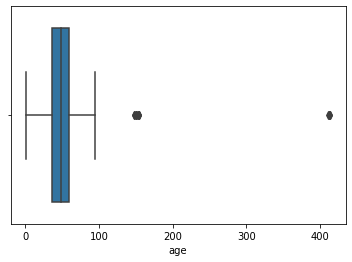

In [ ]:
sns.boxplot(df_all.age)

It turns out that there are some outlier (noise) of the data. Assuming the maximum of the age is 100, we shall elimiate values larger than 100.

In [ ]:
df_all = df_all[df_all.age<=100]
print(df_all.shape)
df_all[:10]

(76996, 4)


,pid,age,sex,label
0,1,58,M,Cardiomegaly
1,1,58,M,Emphysema
2,1,58,M,Effusion
3,2,81,M,No Finding
4,3,81,F,Hernia
5,3,74,F,Hernia
6,3,75,F,Hernia
7,3,76,F,Hernia
8,3,76,F,Infiltration
9,3,77,F,Hernia


Now the outliers has been elimiated. However, things are not done yet. In rows 3 to 9, the same patient may have different age values! After investigation on the original feature of the NIH data, I realize the reason is due to the different follow-up IDs. Which means, a patient may take X-rays image in different periods. For simplicity, I ignore the follow-up ID and take the mean age for each patient. To do this, let's use the transformation with lambda function.

In [ ]:
df_all["age"] = df_all.groupby("pid")["age"].transform(lambda x: int(np.mean(x)))
df_all = df_all.drop_duplicates().reset_index().drop("index", axis=1)
print(df_all.shape)
df_all[:10]

(59795, 4)


,pid,age,sex,label
0,1,58,M,Cardiomegaly
1,1,58,M,Emphysema
2,1,58,M,Effusion
3,2,81,M,No Finding
4,3,77,F,Hernia
5,3,77,F,Infiltration
6,4,82,M,Mass
7,4,82,M,Nodule
8,5,69,F,No Finding
9,5,69,F,Infiltration


This time, the value of age becomes identical for each patient.

Lastly, we shall make sure whether the age value and sex are unique given a patient ID. To do this, let's ignore the finding labels and drop duplicate entries, and check if all PIDs have a unique age and sex. That's being said, each PID should have a unique row because, if a patient ID does not have a unique age or sex, such ID should appear in multiple rows.

In [ ]:
df_meta = df_all.drop("label", axis=1).drop_duplicates()
df_meta.head()

,pid,age,sex
0,1,58,M
3,2,81,M
4,3,77,F
6,4,82,M
8,5,69,F


In [ ]:
df_meta.pid.is_unique

True

Since each PID has unique row, we can ensure that each patient has been assigned an unique age and sex.

To conclude, in this section we have done:
1. Split multi-labeled entries into multiple rows with unique label.
2. Convert age values into numerical values.
3. Elimiate age values which exceeds 100.
4. Average age values given a patient ID for simplicity.

<h2><b><u>3. Data Analysis</u></b></h2>

After pre-processing our data, we can analyze our data distribution.

First, we look at the age distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


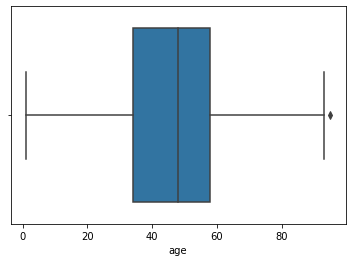

In [ ]:
sns.boxplot(df_meta.age)

Here, the medium of the age is about 50, and the range of the age is about 90.

Second, let's look at the gender distribution:

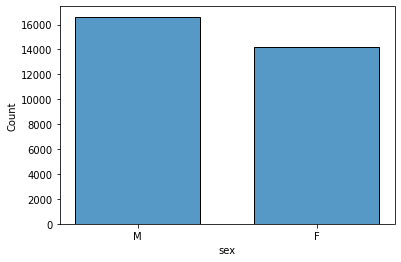

In [ ]:
sns.histplot(df_meta.sex, shrink=.7)

There are more males than females, but the difference is not noticeable.

Finally, let's look at the label distribution:

In [ ]:
df_all.label.value_counts()

No Finding            24909
Infiltration           8029
Atelectasis            4973
Effusion               4273
Nodule                 3390
Mass                   2549
Consolidation          2150
Pleural_Thickening     2006
Cardiomegaly           1565
Pneumothorax           1484
Fibrosis               1260
Edema                  1072
Emphysema              1046
Pneumonia               955
Hernia                  134
Name: label, dtype: int64

Within the 15 classes, "No Finding" appears most frequently, and Hernia appears least frequently. This makes sense since healthy people should be more than the sickness (otherwise most people should live in hospitals...)

To sum up, we have these findings:
1. most of the patients are middle-aged, and the range of patients is about 90.
2. Male patients are more than female patients.
3. Most images are presented "No findings", and the rarest disease is Hernia in this dataset.

<h2><b><u>4. Hypothesis Testing</u></b></h2>

Until now, we make an naive analysis to our data. However, to ensure that our data does not have sample bias, we shall look deeper using hypothesis testing.

In this section, I will test:

1. whether the age distribution is normally distributed or not?
2. given certain types of disease, whether the age distribution is normally distributed?
3. do males and females have the same expected value of age? 

**[4-1] Whether the age distribution is normally distributed or not?**

To do this, let's first visualize the age distribution using boxplot first:

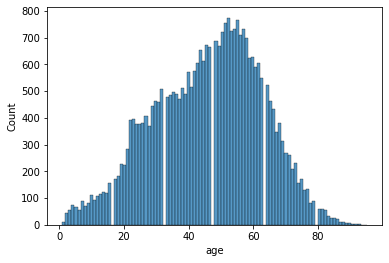

In [ ]:
sns.histplot(df_meta.age, bins=100)

Though it seems like a normal distribution, we need to test it for sure. However, we cannot use *scipy.stats.normaltest* here, since our age data is **categorical** (integer values only). 

If we simply conduct the *scipy.stats.normaltest*, it will produce a p-value:

In [ ]:
_, p = normaltest(df_meta.age)
p

1.0485765585449507e-163

Which is extremely small. Such normality test is only suitable for continuous data distribution.

**To assess normality for our categorical data**, we use a heuristic approach:
1. Calculate the mean and standard deviation of the age data
2. Sample sufficient samples (e.g. 10,000,000) from a normal distribution given the the calculated mean and standard deviation
3. Categorized and squeezed the age samples to integers between [1, 100]
4. Use Chi-square test to judge whether the age distribution is similar to the sampled distribution

The assumption we made here is that the sampled distribution can represent the normal distribution, since we sample large enough data. Note that if we increase the sample size, the judgment will be more reliable since the sample data can be more approximated to normal.

Of course, this is a heuristic method and **does not guarantee the best way to evaluate** whether a categorical is approximately normal.

Now we do the approximation to our age data:

In [ ]:
np.random.seed(0)

mean, std = np.mean(df_meta.age), np.std(df_meta.age)
sample = np.random.normal(mean, std, 10000000)
sample = [int(x) for x in sample if int(x) > 0 and int(x) <= 100] # categorize

We can use the histogram to see what happens here:

Text(0.5, 1.0, 'Age Distribution')

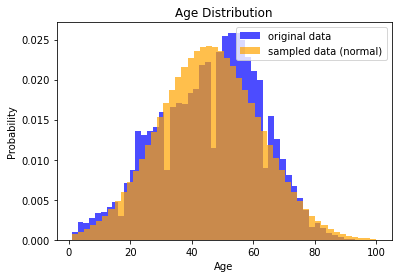

In [ ]:
n1, _, _ = plt.hist(df_meta.age, color="blue", density=True, bins=50, alpha=0.7, label="original data")
n2, _, _ = plt.hist(sample, color="orange", density=True, bins=50, alpha=0.7, label="sampled data (normal)")
plt.legend(loc="best")
plt.xlabel("Age")
plt.ylabel("Probability")
plt.title("Age Distribution")

Again, we **assume** that the sampled data can be approximated to the normal distribution, and can be used for judging the normality of categorical data.

Next, we use the chi-square test to see whether the two distributions are similar. To be more specific, we have a null hypothesis and an alternative hypothesis according to the [chi-square test documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html):


*   H0: The age distribution has the frequencies given by a sampled normal distribution.
*   H1: The age distribution does not have the frequencies given by a sampled normal distribution.

First, let's define our *normaltest* for discrete version:



In [ ]:
def normaltest_discrete(n1, n2, trial, is_plot=True):
  N1 = (n1*trial)
  N2 = (n2*trial)

  if is_plot:
    plt.plot(N1, color="blue", label="original data")
    plt.plot(N2, color="orange", label="sampled data (normal)")
    plt.legend(loc="best")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.title("Simulated Output (trial={})".format(trial))

  _, p = chisquare(N1, N2)
  return p


There are some parameters above:

*   n1: density value of the histogram bins #1
*   n2: density value of the histogram bins #2
*   trial: # of experimental trials
*   is_plot: whether to visualize using *matplotlib*

Note that *scipy.stats.chisquare* should have the number of observations as input (instead of the probability), so we need to simulate some synthetic observations by multiplying the probability by number of trials. The number of trials is a hyper-parameter we shall tune by ourselves.

First, let's set number of trial as 1000, and the corresponded p-value is:

0.062421445802256156

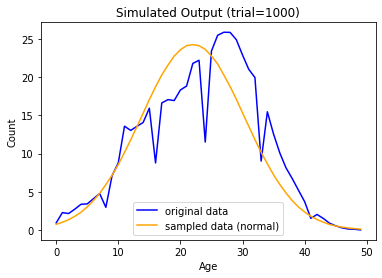

In [ ]:
normaltest_discrete(n1, n2, 1000)



Since the p-value is larger than 0.05, we fail to reject the null hypothesis. Considering the 1000-trials experiment, we acknowledge that **the age distribution approximates to the frequencies given by a normal distribution**.

However, the number of trials strongly affects the p-value, because larger number of trials yields a more strict rule of similarity measurement. Let's try different number of trials to show what it means:

0.9999999999999497

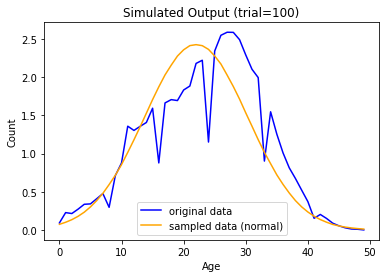

In [ ]:
normaltest_discrete(n1, n2, 100)

6.091051967725855e-106

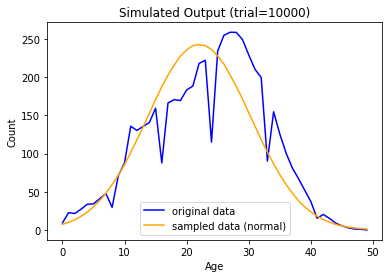

In [ ]:
normaltest_discrete(n1, n2, 10000)

We see that:


*   If we set a small # trials (100), the p-value becomes very large, which makes the null hypothesis more acceptable.
*   If we set a huge # trials (10000), the p-value becomes very small, which makes the null hypothesis very unlikely.

Therefore, the sample bias should be a big issue here. For simplicity, I ignore such an underlying problem and assume that 1000-trial is okay for the *discrete version* of the normality test.



**[4-2] Given certain types of disease, whether the age distribution is normally distributed?**

Here, we will do the same *heuristic* statistical test method described above. 

Given a certain type of disease, we can draw a corresponded histogram plot:

[]

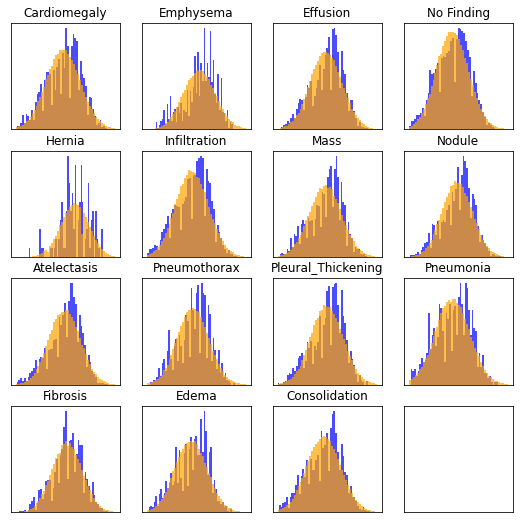

In [ ]:
np.random.seed(0)

origin_lst = []
sample_lst = []

fig, axes = plt.subplots(4, 4)
fig.set_size_inches(9, 9)
for ax, label in zip(axes.ravel(), df_all.label.unique()):
  # original data
  df_partial = df_all[df_all.label == label].drop("label", axis=1).drop_duplicates()
  n1, _, _ = ax.hist(df_partial.age, bins=50, color="blue", density=True, alpha=0.7)
  origin_lst.append(n1)

  # sample data from normal distribution
  sample = np.random.normal(np.mean(df_partial.age), np.std(df_partial.age), 100000)
  sample = [int(x) for x in sample if int(x) > 0 and int(x) <= 100] # categorize
  n2, _, _ = ax.hist(sample, bins=50, color="orange", density=True, alpha=0.7)
  sample_lst.append(n2)

  # Remove the ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(label)
axes[3,3].set_xticks([])
axes[3,3].set_yticks([])

Note that the blue histogram represents the original data, and the orange one represents the sample data retrieved from a categorized normal distribution. Next, given a disease, we want to calculate whether each distribution is approximately normal. The null hypothesis and the alternative hypothesis are:

*   H0: The age distribution given by a certain disease has the frequencies given by a sampled normal distribution.
*   H1: The age distribution given by a certain disease does not have the frequencies given by a sampled normal distribution.


In [ ]:
df_p = []
for label, origin, sample in zip(df_all.label.unique(), origin_lst, sample_lst):
  p = normaltest_discrete(origin, sample, 1000, is_plot=False)
  df_p.append({"label": label, "p-value": p})
df_p = pd.DataFrame(df_p)

In [ ]:
df_p = df_p.sort_values("p-value", ascending=False).reset_index().drop("index", axis=1)
df_p[:5]

,label,p-value
0,No Finding,9.624230e-02
1,Consolidation,2.188610e-07
2,Infiltration,2.888963e-08
3,Nodule,3.376059e-09
4,Atelectasis,1.296929e-10


We can see that only "No Finding" yields a p-value larger than 0.05, and the others yield p-values so small that we shall reject the null.

That is to say, **only "No Findings" approximates a normal distribution, but the others are not.**

**[4-3] do males and females have the same expected value of age?** 

Here we can use *scipy.stats.ttest_ind*. This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

First, we separate our age data into male and female groups:

In [ ]:
df_male = df_meta[df_meta.sex == "M"]
df_female = df_meta[df_meta.sex == "F"]

len(df_male), len(df_female)

(16629, 14173)

To test whether two samples have identical variances, we can calculate it using *np.std*:

In [ ]:
np.std(df_male.age), np.std(df_female.age)

(17.09185313334399, 16.11211600798153)

Since these two values are very closed to each other, we assume they have identical variances.

Next, we show their density histgram plots:

Text(0.5, 1.0, 'Density Histogram (nbins=20)')

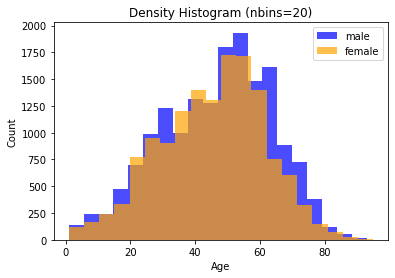

In [ ]:
N1, _, _ = plt.hist(df_male.age, bins=20, color="blue", alpha=0.7, label="male")
N2, _, _ = plt.hist(df_female.age, bins=20, color="orange", alpha=0.7, label="female")
plt.legend(loc="best")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Density Histogram (nbins=20)")

Each bin in the histogram has a range of 5, since we separate the whole range [1, 100] into 20 bins.

Finally, we do the statistical test using *scipy.stats.ttest_ind*. The null hypothesis and the alternative hypothesis are:



*   H0: two independent samples (male & female) have identical expected values.
*   H1: two independent samples (male & female) do not have identical expected values.



In [ ]:
_, p = ttest_ind(N1, N2)
p

0.521818261903512

Since the p-value is larger than 0.05, we fail to reject the null hypothesis. 

That is to say, **the male group and the female group have the same averaged age value.**

<h2><b><u>5. Conclusions</u></b></h2>

In this project, we collect the NIH Chest X-ray dataset.

1.   **In the Data Preparation phase**, we found its metadata contains 12 columns, and one of the columns represents several kinds of finding labels.
2.   **In the Feature Engineering phase**, we remove outlier values in the age column, taking the average for the same patient, and split labels into several rows with unique values.
3.   **In the Data Analysis phase**, we found most patients are middle-aged and male, and the dominant label is "No Finding" (i.e. healthy)
4.   **In the Hypothesis Testing phase**, we use an approximation approach to state that the age distribution is normally distributed. Besides, each distribution given a certain type of disease is not normally distributed, except "No Findings". Finally, the male data and female data have the same expected age values.

<h2><b><u>6. Future Works</u></b></h2>

In our hypothesis-testing phase, we use an approximation approach to test the normality for discrete data distribution. However, there is no evidence that such a method is convincing or theoretical.

Many real-world datasets include continuous features, such as people's height, ages, or days of recovery. However, all of these examples have discrete values, since their data types are integers instead of precise floating point numbers. How could we judge whether such data are normally distributed? We may need to figure out a better solution to approximate a normal test for a continuous case in the future.